In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.data_loader import load_rfm_data
from src.config.config_loader import get_config

plt.rcParams["font.family"] = "Tahoma"

df = pd.read_csv("../data/customer_clusters.csv")
df.head()

,CustomerCode,Cluster
0,C20010518,3
1,C20011239,0
2,C20011464,1
3,C20011480,1
4,C20011516,0


In [3]:
config = get_config()
cols = config["rfm_columns"]
ref_date = datetime.strptime(config["recency_reference_date"], "%Y-%m-%d")

full_data = load_rfm_data()

entry_dates = pd.to_datetime(full_data[cols["recency"]], errors="coerce")
recency_days = (ref_date - entry_dates).dt.days

analysis_df = pd.DataFrame(
    {
        cols["customer_id"]: full_data[cols["customer_id"]],
        "Recency": recency_days,
        "Frequency": full_data[cols["frequency"]],
        "Monetary": full_data[cols["monetary"]],
        "ReturnRate": full_data[cols["return_rate"]],
    }
)

cluster_df = pd.read_csv("../data/customer_clusters.csv")
merged = pd.merge(cluster_df, analysis_df, on=cols["customer_id"])
merged.head()

{"timestamp": "2025-09-07T22:11:12", "level": "INFO", "module": "src.data_loader", "message": "Starting to load RFM data from SQL"}
{"timestamp": "2025-09-07T22:11:12", "level": "INFO", "module": "src.data_loader", "message": "Connecting to SQL Server: ., Database: Uni, Table: CustomerData"}
{"timestamp": "2025-09-07T22:11:12", "level": "INFO", "module": "src.data_loader", "message": "RFM data loaded successfully. Shape: (1649, 5)"}


,CustomerCode,Cluster,Recency,Frequency,Monetary,ReturnRate
0,C20010518,3,18,9,74331195,18.18
1,C20011239,0,113,34,98508953,8.11
2,C20011464,1,68,9,34999975,10.00
3,C20011480,1,1,62,201608976,8.82
4,C20011516,0,143,16,117271597,0.00


In [4]:
stats = (
    merged.groupby("Cluster")
    .agg(
        {
            "Recency": ["mean"],
            "Frequency": ["mean"],
            "Monetary": ["mean"],
            "ReturnRate": ["mean"],
            "CustomerCode": "count",
        }
    )
    .rename(columns={"CustomerCode": "Count"})
)

stats

,Recency,Frequency,Monetary,ReturnRate,Count
,mean,mean,mean,mean,count
Cluster,,,,,
0,181.279279,15.270270,8.716182e+07,1.681036,222
1,26.061388,32.264235,1.662713e+08,1.854546,1124
2,19.953488,280.558140,1.264413e+10,4.132093,43
3,41.107692,27.730769,9.678738e+07,21.155846,260


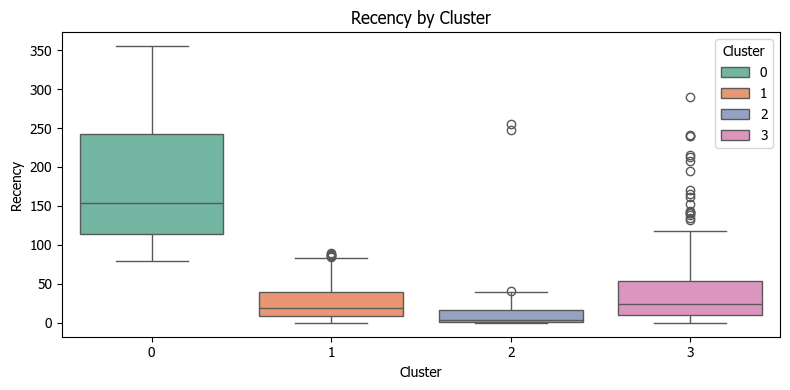

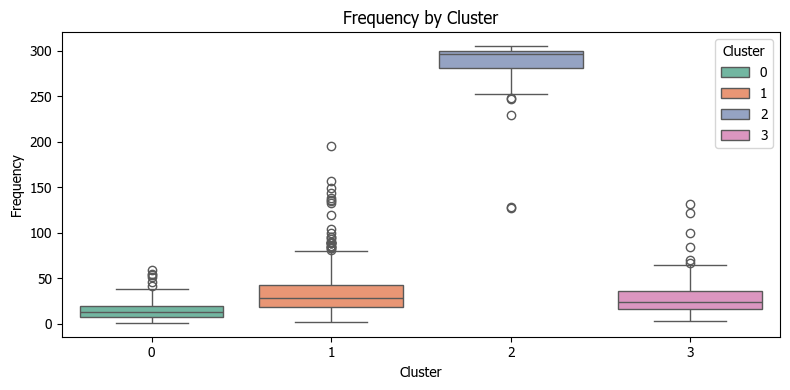

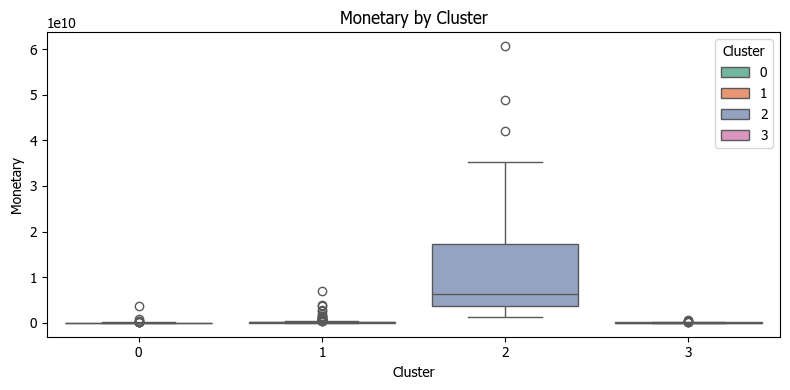

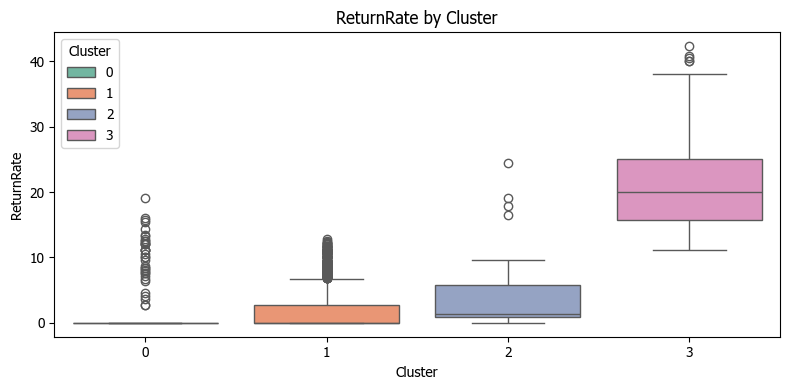

In [10]:
features = ["Recency", "Frequency", "Monetary", "ReturnRate"]

for col in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2", hue="Cluster")
    plt.title(f"{col} by Cluster")
    plt.tight_layout()
    plt.show()

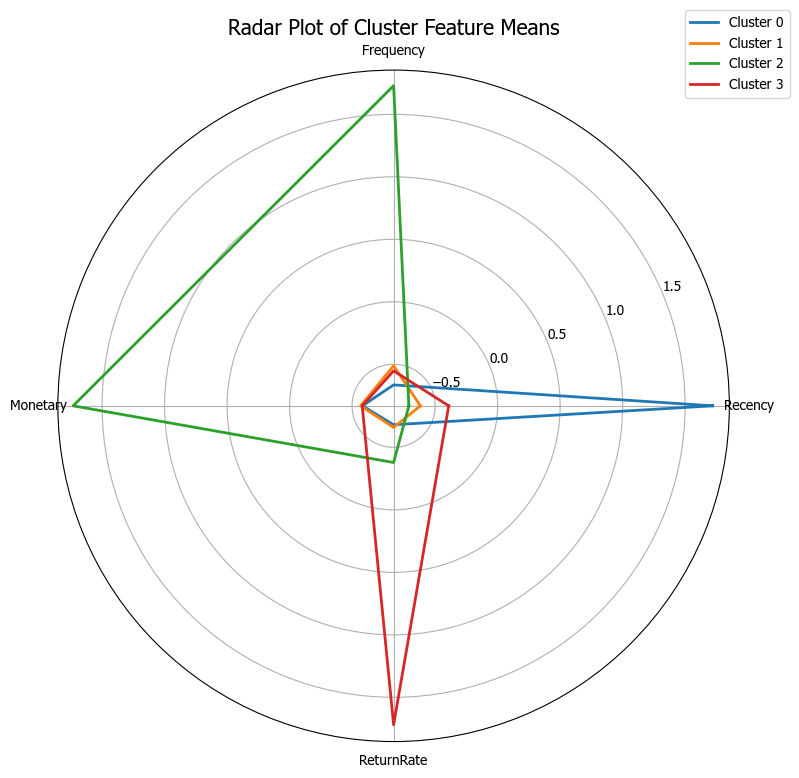

In [11]:
radar_data = merged.groupby("Cluster")[features].mean()
radar_scaled = StandardScaler().fit_transform(radar_data)
radar_df = pd.DataFrame(radar_scaled, columns=features, index=radar_data.index)

categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
for i, row in radar_df.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {i}", linewidth=2)

plt.xticks(angles[:-1], categories)
plt.title("Radar Plot of Cluster Feature Means", size=15)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

In [12]:
overall_means = merged[features].mean()
group_means = merged.groupby("Cluster")[features].mean()

for cluster_id, row in group_means.iterrows():
    print(f"Cluster {cluster_id}:")

    for feature in features:
        if row[feature] > overall_means[feature]:
            print(f"🔼 {feature} بالاتر از میانگین کل ({row[feature]:.2f})")
        else:
            print(f"🔽 {feature} پایین‌تر از میانگین کل ({row[feature]:.2f})")

    print("-" * 50)

Cluster 0:
🔼 Recency بالاتر از میانگین کل (181.28)
🔽 Frequency پایین‌تر از میانگین کل (15.27)
🔽 Monetary پایین‌تر از میانگین کل (87161824.27)
🔽 ReturnRate پایین‌تر از میانگین کل (1.68)
--------------------------------------------------
Cluster 1:
🔽 Recency پایین‌تر از میانگین کل (26.06)
🔽 Frequency پایین‌تر از میانگین کل (32.26)
🔽 Monetary پایین‌تر از میانگین کل (166271345.37)
🔽 ReturnRate پایین‌تر از میانگین کل (1.85)
--------------------------------------------------
Cluster 2:
🔽 Recency پایین‌تر از میانگین کل (19.95)
🔼 Frequency بالاتر از میانگین کل (280.56)
🔼 Monetary بالاتر از میانگین کل (12644130719.60)
🔽 ReturnRate پایین‌تر از میانگین کل (4.13)
--------------------------------------------------
Cluster 3:
🔽 Recency پایین‌تر از میانگین کل (41.11)
🔽 Frequency پایین‌تر از میانگین کل (27.73)
🔽 Monetary پایین‌تر از میانگین کل (96787382.95)
🔼 ReturnRate بالاتر از میانگین کل (21.16)
--------------------------------------------------
